In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 9*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 9*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 9*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [5]:
start_time = time.time()
n_epochs = 5000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p9_9pi_5k.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p9_9pi_5k.pth')

################################  0  ################################
Loss:  143.15081787109375
################################  1  ################################
Loss:  142.78672790527344
################################  2  ################################
Loss:  125.70880126953125
################################  3  ################################
Loss:  103.67759704589844
################################  4  ################################
Loss:  88.28973388671875
################################  5  ################################
Loss:  81.12934875488281
################################  6  ################################
Loss:  76.37478637695312
################################  7  ################################
Loss:  72.48036193847656
################################  8  ################################
Loss:  69.17800903320312
################################  9  ################################
Loss:  66.35520935058594
################################  10  ########

Loss:  40.08450698852539
################################  86  ################################
Loss:  40.006080627441406
################################  87  ################################
Loss:  39.929840087890625
################################  88  ################################
Loss:  39.85679626464844
################################  89  ################################
Loss:  39.785491943359375
################################  90  ################################
Loss:  39.71731185913086
################################  91  ################################
Loss:  39.64985656738281
################################  92  ################################
Loss:  39.584938049316406
################################  93  ################################
Loss:  39.51902770996094
################################  94  ################################
Loss:  39.45390701293945
################################  95  ################################
Loss:  39.384803771972656
##########

Loss:  31.964046478271484
################################  171  ################################
Loss:  31.731178283691406
################################  172  ################################
Loss:  31.53589630126953
################################  173  ################################
Loss:  31.34669303894043
################################  174  ################################
Loss:  31.203025817871094
################################  175  ################################
Loss:  31.054950714111328
################################  176  ################################
Loss:  30.925979614257812
################################  177  ################################
Loss:  30.80746841430664
################################  178  ################################
Loss:  30.690937042236328
################################  179  ################################
Loss:  30.576854705810547
################################  180  ################################
Loss:  30.4602355957031

Loss:  24.196884155273438
################################  255  ################################
Loss:  24.152877807617188
################################  256  ################################
Loss:  24.111839294433594
################################  257  ################################
Loss:  24.069469451904297
################################  258  ################################
Loss:  24.031795501708984
################################  259  ################################
Loss:  23.99163818359375
################################  260  ################################
Loss:  23.954801559448242
################################  261  ################################
Loss:  23.91423225402832
################################  262  ################################
Loss:  23.876445770263672
################################  263  ################################
Loss:  23.835960388183594
################################  264  ################################
Loss:  23.796699523925

Loss:  19.6707763671875
################################  339  ################################
Loss:  19.56132698059082
################################  340  ################################
Loss:  19.45956039428711
################################  341  ################################
Loss:  19.359403610229492
################################  342  ################################
Loss:  19.268287658691406
################################  343  ################################
Loss:  19.19888687133789
################################  344  ################################
Loss:  19.1304931640625
################################  345  ################################
Loss:  19.064193725585938
################################  346  ################################
Loss:  18.986967086791992
################################  347  ################################
Loss:  18.91022300720215
################################  348  ################################
Loss:  18.838497161865234
##

Loss:  8.403367042541504
################################  423  ################################
Loss:  8.2806978225708
################################  424  ################################
Loss:  8.158548355102539
################################  425  ################################
Loss:  8.047294616699219
################################  426  ################################
Loss:  7.940271377563477
################################  427  ################################
Loss:  7.843231201171875
################################  428  ################################
Loss:  7.748571395874023
################################  429  ################################
Loss:  7.659000396728516
################################  430  ################################
Loss:  7.569378852844238
################################  431  ################################
Loss:  7.48331880569458
################################  432  ################################
Loss:  7.39632511138916
#########

Loss:  3.26790189743042
################################  508  ################################
Loss:  3.233527898788452
################################  509  ################################
Loss:  3.200249671936035
################################  510  ################################
Loss:  3.1698434352874756
################################  511  ################################
Loss:  3.138685464859009
################################  512  ################################
Loss:  3.108908176422119
################################  513  ################################
Loss:  3.0786027908325195
################################  514  ################################
Loss:  3.048928737640381
################################  515  ################################
Loss:  3.012984037399292
################################  516  ################################
Loss:  2.9801676273345947
################################  517  ################################
Loss:  2.943511724472046
###

Loss:  1.5478466749191284
################################  592  ################################
Loss:  1.5375792980194092
################################  593  ################################
Loss:  1.5270131826400757
################################  594  ################################
Loss:  1.5166287422180176
################################  595  ################################
Loss:  1.5061070919036865
################################  596  ################################
Loss:  1.4958670139312744
################################  597  ################################
Loss:  1.4855226278305054
################################  598  ################################
Loss:  1.4753940105438232
################################  599  ################################
Loss:  1.4650722742080688
################################  600  ################################
Loss:  1.4549132585525513
################################  601  ################################
Loss:  1.44440722465

Loss:  0.7682983875274658
################################  676  ################################
Loss:  0.7621145844459534
################################  677  ################################
Loss:  0.7563046813011169
################################  678  ################################
Loss:  0.7502123117446899
################################  679  ################################
Loss:  0.7444046139717102
################################  680  ################################
Loss:  0.7386132478713989
################################  681  ################################
Loss:  0.7330502271652222
################################  682  ################################
Loss:  0.7275583148002625
################################  683  ################################
Loss:  0.7223817110061646
################################  684  ################################
Loss:  0.7173479795455933
################################  685  ################################
Loss:  0.71257185935

Loss:  0.4602416455745697
################################  760  ################################
Loss:  0.45656976103782654
################################  761  ################################
Loss:  0.45298701524734497
################################  762  ################################
Loss:  0.4497253894805908
################################  763  ################################
Loss:  0.4466246962547302
################################  764  ################################
Loss:  0.44385457038879395
################################  765  ################################
Loss:  0.44138020277023315
################################  766  ################################
Loss:  0.4391244053840637
################################  767  ################################
Loss:  0.43688082695007324
################################  768  ################################
Loss:  0.4342706799507141
################################  769  ################################
Loss:  0.431524

Loss:  0.27042239904403687
################################  844  ################################
Loss:  0.26854419708251953
################################  845  ################################
Loss:  0.2666555643081665
################################  846  ################################
Loss:  0.26480191946029663
################################  847  ################################
Loss:  0.26291394233703613
################################  848  ################################
Loss:  0.2610321640968323
################################  849  ################################
Loss:  0.2590945363044739
################################  850  ################################
Loss:  0.25718218088150024
################################  851  ################################
Loss:  0.255196213722229
################################  852  ################################
Loss:  0.2532012462615967
################################  853  ################################
Loss:  0.2510996

Loss:  0.15825441479682922
################################  927  ################################
Loss:  0.15693128108978271
################################  928  ################################
Loss:  0.15564286708831787
################################  929  ################################
Loss:  0.15429192781448364
################################  930  ################################
Loss:  0.1529930830001831
################################  931  ################################
Loss:  0.1517886519432068
################################  932  ################################
Loss:  0.1503242701292038
################################  933  ################################
Loss:  0.14919999241828918
################################  934  ################################
Loss:  0.1479775309562683
################################  935  ################################
Loss:  0.14669230580329895
################################  936  ################################
Loss:  0.14546

Loss:  0.09810829162597656
################################  1010  ################################
Loss:  0.09744302928447723
################################  1011  ################################
Loss:  0.09678448736667633
################################  1012  ################################
Loss:  0.09615249186754227
################################  1013  ################################
Loss:  0.09553647041320801
################################  1014  ################################
Loss:  0.09495025128126144
################################  1015  ################################
Loss:  0.09438174962997437
################################  1016  ################################
Loss:  0.09384088218212128
################################  1017  ################################
Loss:  0.09331861883401871
################################  1018  ################################
Loss:  0.0928390622138977
################################  1019  ################################
L

Loss:  0.06640191376209259
################################  1093  ################################
Loss:  0.06617450714111328
################################  1094  ################################
Loss:  0.06593896448612213
################################  1095  ################################
Loss:  0.06568989157676697
################################  1096  ################################
Loss:  0.06543165445327759
################################  1097  ################################
Loss:  0.06516222655773163
################################  1098  ################################
Loss:  0.06488756835460663
################################  1099  ################################
Loss:  0.06460513174533844
################################  1100  ################################
Loss:  0.0643203929066658
################################  1101  ################################
Loss:  0.06402599811553955
################################  1102  ################################
L

Loss:  0.04756457731127739
################################  1175  ################################
Loss:  0.047399215400218964
################################  1176  ################################
Loss:  0.04722106456756592
################################  1177  ################################
Loss:  0.04706182703375816
################################  1178  ################################
Loss:  0.046908337622880936
################################  1179  ################################
Loss:  0.04674919694662094
################################  1180  ################################
Loss:  0.04658618941903114
################################  1181  ################################
Loss:  0.04641959071159363
################################  1182  ################################
Loss:  0.0462552011013031
################################  1183  ################################
Loss:  0.046091753989458084
################################  1184  ###############################

Loss:  0.03469882160425186
################################  1257  ################################
Loss:  0.03457885980606079
################################  1258  ################################
Loss:  0.03445648401975632
################################  1259  ################################
Loss:  0.03433366119861603
################################  1260  ################################
Loss:  0.03419993072748184
################################  1261  ################################
Loss:  0.034060027450323105
################################  1262  ################################
Loss:  0.03394325450062752
################################  1263  ################################
Loss:  0.03382903337478638
################################  1264  ################################
Loss:  0.03371956944465637
################################  1265  ################################
Loss:  0.03360601142048836
################################  1266  ################################

Loss:  0.027636907994747162
################################  1339  ################################
Loss:  0.02756880596280098
################################  1340  ################################
Loss:  0.027502555400133133
################################  1341  ################################
Loss:  0.027436373755335808
################################  1342  ################################
Loss:  0.027370009571313858
################################  1343  ################################
Loss:  0.027303962036967278
################################  1344  ################################
Loss:  0.02723817154765129
################################  1345  ################################
Loss:  0.0271726343780756
################################  1346  ################################
Loss:  0.02710741013288498
################################  1347  ################################
Loss:  0.02704230323433876
################################  1348  #############################

Loss:  0.021930452436208725
################################  1421  ################################
Loss:  0.021841751411557198
################################  1422  ################################
Loss:  0.021760862320661545
################################  1423  ################################
Loss:  0.021682370454072952
################################  1424  ################################
Loss:  0.021608738228678703
################################  1425  ################################
Loss:  0.021537646651268005
################################  1426  ################################
Loss:  0.021470779553055763
################################  1427  ################################
Loss:  0.02140985056757927
################################  1428  ################################
Loss:  0.021354492753744125
################################  1429  ################################
Loss:  0.021299617365002632
################################  1430  ########################

Loss:  0.01731392927467823
################################  1503  ################################
Loss:  0.017266418784856796
################################  1504  ################################
Loss:  0.017211291939020157
################################  1505  ################################
Loss:  0.017175354063510895
################################  1506  ################################
Loss:  0.017139341682195663
################################  1507  ################################
Loss:  0.01709921285510063
################################  1508  ################################
Loss:  0.017055217176675797
################################  1509  ################################
Loss:  0.017008928582072258
################################  1510  ################################
Loss:  0.016960464417934418
################################  1511  ################################
Loss:  0.016911443322896957
################################  1512  #########################

Loss:  0.014731291681528091
################################  1585  ################################
Loss:  0.014699419029057026
################################  1586  ################################
Loss:  0.014667641371488571
################################  1587  ################################
Loss:  0.014638643711805344
################################  1588  ################################
Loss:  0.014612028375267982
################################  1589  ################################
Loss:  0.014584776014089584
################################  1590  ################################
Loss:  0.014558686874806881
################################  1591  ################################
Loss:  0.014532782137393951
################################  1592  ################################
Loss:  0.014508293010294437
################################  1593  ################################
Loss:  0.014484596438705921
################################  1594  #######################

Loss:  0.012964824214577675
################################  1667  ################################
Loss:  0.012950355187058449
################################  1668  ################################
Loss:  0.012935852631926537
################################  1669  ################################
Loss:  0.012921708635985851
################################  1670  ################################
Loss:  0.012907613068819046
################################  1671  ################################
Loss:  0.012892436236143112
################################  1672  ################################
Loss:  0.012878341600298882
################################  1673  ################################
Loss:  0.01286359690129757
################################  1674  ################################
Loss:  0.012847952544689178
################################  1675  ################################
Loss:  0.012830858118832111
################################  1676  ########################

Loss:  0.011411426588892937
################################  1749  ################################
Loss:  0.011388307437300682
################################  1750  ################################
Loss:  0.011362269520759583
################################  1751  ################################
Loss:  0.011343015357851982
################################  1752  ################################
Loss:  0.011327674612402916
################################  1753  ################################
Loss:  0.01131189614534378
################################  1754  ################################
Loss:  0.011298248544335365
################################  1755  ################################
Loss:  0.011284805834293365
################################  1756  ################################
Loss:  0.011273140087723732
################################  1757  ################################
Loss:  0.011261269450187683
################################  1758  ########################

Loss:  0.010683774016797543
################################  1831  ################################
Loss:  0.01067805103957653
################################  1832  ################################
Loss:  0.010671439580619335
################################  1833  ################################
Loss:  0.010663972236216068
################################  1834  ################################
Loss:  0.010655905120074749
################################  1835  ################################
Loss:  0.01064726896584034
################################  1836  ################################
Loss:  0.010638264939188957
################################  1837  ################################
Loss:  0.01062837615609169
################################  1838  ################################
Loss:  0.010618381202220917
################################  1839  ################################
Loss:  0.010607210919260979
################################  1840  ##########################

Loss:  0.010169856250286102
################################  1913  ################################
Loss:  0.010163262486457825
################################  1914  ################################
Loss:  0.010157128795981407
################################  1915  ################################
Loss:  0.010151115246117115
################################  1916  ################################
Loss:  0.010145436972379684
################################  1917  ################################
Loss:  0.010140088386833668
################################  1918  ################################
Loss:  0.010134437121450901
################################  1919  ################################
Loss:  0.010129443369805813
################################  1920  ################################
Loss:  0.01012513693422079
################################  1921  ################################
Loss:  0.01012110710144043
################################  1922  #########################

Loss:  0.009547241032123566
################################  1995  ################################
Loss:  0.009535952471196651
################################  1996  ################################
Loss:  0.00952538475394249
################################  1997  ################################
Loss:  0.00951439794152975
################################  1998  ################################
Loss:  0.009504636749625206
################################  1999  ################################
Loss:  0.009495295584201813
################################  2000  ################################
Loss:  0.009486636146903038
################################  2001  ################################
Loss:  0.009477488696575165
################################  2002  ################################
Loss:  0.009470033459365368
################################  2003  ################################
Loss:  0.009462629444897175
################################  2004  #########################

Loss:  0.00909650232642889
################################  2077  ################################
Loss:  0.009094519540667534
################################  2078  ################################
Loss:  0.009092506021261215
################################  2079  ################################
Loss:  0.009090585634112358
################################  2080  ################################
Loss:  0.009088627062737942
################################  2081  ################################
Loss:  0.009086793288588524
################################  2082  ################################
Loss:  0.00908520258963108
################################  2083  ################################
Loss:  0.009083420038223267
################################  2084  ################################
Loss:  0.009081795811653137
################################  2085  ################################
Loss:  0.009078997187316418
################################  2086  #########################

Loss:  0.008820600807666779
################################  2159  ################################
Loss:  0.008820547722280025
################################  2160  ################################
Loss:  0.00882052257657051
################################  2161  ################################
Loss:  0.008820807561278343
################################  2162  ################################
Loss:  0.008821172639727592
################################  2163  ################################
Loss:  0.008821627125144005
################################  2164  ################################
Loss:  0.00882231816649437
################################  2165  ################################
Loss:  0.008823192678391933
################################  2166  ################################
Loss:  0.008824121206998825
################################  2167  ################################
Loss:  0.008824924938380718
################################  2168  #########################

Loss:  0.008660477586090565
################################  2241  ################################
Loss:  0.008655291981995106
################################  2242  ################################
Loss:  0.008649814873933792
################################  2243  ################################
Loss:  0.008644189685583115
################################  2244  ################################
Loss:  0.008638514205813408
################################  2245  ################################
Loss:  0.008633123710751534
################################  2246  ################################
Loss:  0.008627766743302345
################################  2247  ################################
Loss:  0.00862284004688263
################################  2248  ################################
Loss:  0.008618185296654701
################################  2249  ################################
Loss:  0.008613795042037964
################################  2250  ########################

Loss:  0.008305748924612999
################################  2323  ################################
Loss:  0.008299807086586952
################################  2324  ################################
Loss:  0.008295590057969093
################################  2325  ################################
Loss:  0.008290978148579597
################################  2326  ################################
Loss:  0.008287474513053894
################################  2327  ################################
Loss:  0.008282975293695927
################################  2328  ################################
Loss:  0.008280000649392605
################################  2329  ################################
Loss:  0.008276781067252159
################################  2330  ################################
Loss:  0.008273711428046227
################################  2331  ################################
Loss:  0.008270254358649254
################################  2332  #######################

Loss:  0.008008277043700218
################################  2405  ################################
Loss:  0.008006121963262558
################################  2406  ################################
Loss:  0.008004129864275455
################################  2407  ################################
Loss:  0.008001739159226418
################################  2408  ################################
Loss:  0.007995808497071266
################################  2409  ################################
Loss:  0.007991770282387733
################################  2410  ################################
Loss:  0.007987064309418201
################################  2411  ################################
Loss:  0.007981332018971443
################################  2412  ################################
Loss:  0.007975300773978233
################################  2413  ################################
Loss:  0.007968258112668991
################################  2414  #######################

Loss:  0.0077841756865382195
################################  2487  ################################
Loss:  0.00778344739228487
################################  2488  ################################
Loss:  0.007782288361340761
################################  2489  ################################
Loss:  0.007781400810927153
################################  2490  ################################
Loss:  0.007780606858432293
################################  2491  ################################
Loss:  0.0077881840988993645
################################  2492  ################################
Loss:  0.007786874659359455
################################  2493  ################################
Loss:  0.0077852895483374596
################################  2494  ################################
Loss:  0.007783953566104174
################################  2495  ################################
Loss:  0.007782141678035259
################################  2496  #####################

Loss:  0.007710189558565617
################################  2569  ################################
Loss:  0.007708731107413769
################################  2570  ################################
Loss:  0.007706822361797094
################################  2571  ################################
Loss:  0.007705148309469223
################################  2572  ################################
Loss:  0.007703050505369902
################################  2573  ################################
Loss:  0.00770115340128541
################################  2574  ################################
Loss:  0.007699047215282917
################################  2575  ################################
Loss:  0.007697095163166523
################################  2576  ################################
Loss:  0.007694924250245094
################################  2577  ################################
Loss:  0.007692691870033741
################################  2578  ########################

Loss:  0.007540138904005289
################################  2651  ################################
Loss:  0.007537988945841789
################################  2652  ################################
Loss:  0.007534649223089218
################################  2653  ################################
Loss:  0.007531432900577784
################################  2654  ################################
Loss:  0.007527641486376524
################################  2655  ################################
Loss:  0.007523911073803902
################################  2656  ################################
Loss:  0.007519714534282684
################################  2657  ################################
Loss:  0.00751563161611557
################################  2658  ################################
Loss:  0.007511320989578962
################################  2659  ################################
Loss:  0.007507239934056997
################################  2660  ########################

Loss:  0.007386388257145882
################################  2733  ################################
Loss:  0.007383742369711399
################################  2734  ################################
Loss:  0.007379263639450073
################################  2735  ################################
Loss:  0.007378182839602232
################################  2736  ################################
Loss:  0.007375708781182766
################################  2737  ################################
Loss:  0.007373133674263954
################################  2738  ################################
Loss:  0.007371166720986366
################################  2739  ################################
Loss:  0.007368728518486023
################################  2740  ################################
Loss:  0.007366555742919445
################################  2741  ################################
Loss:  0.007364310789853334
################################  2742  #######################

Loss:  0.007181634660810232
################################  2815  ################################
Loss:  0.0071794502437114716
################################  2816  ################################
Loss:  0.007177670486271381
################################  2817  ################################
Loss:  0.007175510749220848
################################  2818  ################################
Loss:  0.007173953577876091
################################  2819  ################################
Loss:  0.0071721430867910385
################################  2820  ################################
Loss:  0.0071708643808960915
################################  2821  ################################
Loss:  0.007169226184487343
################################  2822  ################################
Loss:  0.00716806948184967
################################  2823  ################################
Loss:  0.007166942581534386
################################  2824  #####################

Loss:  0.007051694206893444
################################  2897  ################################
Loss:  0.007049766834825277
################################  2898  ################################
Loss:  0.007048019208014011
################################  2899  ################################
Loss:  0.007046021521091461
################################  2900  ################################
Loss:  0.007043980062007904
################################  2901  ################################
Loss:  0.007041658274829388
################################  2902  ################################
Loss:  0.00703931599855423
################################  2903  ################################
Loss:  0.007036777678877115
################################  2904  ################################
Loss:  0.007034227252006531
################################  2905  ################################
Loss:  0.007031268440186977
################################  2906  ########################

Loss:  0.006849898025393486
################################  2979  ################################
Loss:  0.006848731078207493
################################  2980  ################################
Loss:  0.006847066804766655
################################  2981  ################################
Loss:  0.006845665164291859
################################  2982  ################################
Loss:  0.006843813695013523
################################  2983  ################################
Loss:  0.006842197850346565
################################  2984  ################################
Loss:  0.006839652545750141
################################  2985  ################################
Loss:  0.006836323998868465
################################  2986  ################################
Loss:  0.006833053193986416
################################  2987  ################################
Loss:  0.006829029880464077
################################  2988  #######################

Loss:  0.0067641763016581535
################################  3061  ################################
Loss:  0.006762683857232332
################################  3062  ################################
Loss:  0.006760731339454651
################################  3063  ################################
Loss:  0.006759033538401127
################################  3064  ################################
Loss:  0.006757647730410099
################################  3065  ################################
Loss:  0.006755096837878227
################################  3066  ################################
Loss:  0.0067537641152739525
################################  3067  ################################
Loss:  0.006751878187060356
################################  3068  ################################
Loss:  0.006750648841261864
################################  3069  ################################
Loss:  0.00674905302003026
################################  3070  ######################

Loss:  0.006695465184748173
################################  3143  ################################
Loss:  0.006694226525723934
################################  3144  ################################
Loss:  0.006693440023809671
################################  3145  ################################
Loss:  0.006691761314868927
################################  3146  ################################
Loss:  0.006691021844744682
################################  3147  ################################
Loss:  0.006688899360597134
################################  3148  ################################
Loss:  0.00668798852711916
################################  3149  ################################
Loss:  0.006685643456876278
################################  3150  ################################
Loss:  0.006684980820864439
################################  3151  ################################
Loss:  0.006683725863695145
################################  3152  ########################

Loss:  0.0066032023169100285
################################  3225  ################################
Loss:  0.006601948291063309
################################  3226  ################################
Loss:  0.0066003343090415
################################  3227  ################################
Loss:  0.006599060259759426
################################  3228  ################################
Loss:  0.0065973480232059956
################################  3229  ################################
Loss:  0.00659614522010088
################################  3230  ################################
Loss:  0.006594277918338776
################################  3231  ################################
Loss:  0.006593037396669388
################################  3232  ################################
Loss:  0.006591229699552059
################################  3233  ################################
Loss:  0.006590009666979313
################################  3234  ########################

Loss:  0.006581049412488937
################################  3307  ################################
Loss:  0.006581366062164307
################################  3308  ################################
Loss:  0.006581510882824659
################################  3309  ################################
Loss:  0.0065818242728710175
################################  3310  ################################
Loss:  0.006581484340131283
################################  3311  ################################
Loss:  0.006582428701221943
################################  3312  ################################
Loss:  0.006581977941095829
################################  3313  ################################
Loss:  0.006582304835319519
################################  3314  ################################
Loss:  0.006582161877304316
################################  3315  ################################
Loss:  0.006582368165254593
################################  3316  ######################

Loss:  0.006615261547267437
################################  3389  ################################
Loss:  0.006614385638386011
################################  3390  ################################
Loss:  0.006614404730498791
################################  3391  ################################
Loss:  0.006613338366150856
################################  3392  ################################
Loss:  0.006613512523472309
################################  3393  ################################
Loss:  0.006612639874219894
################################  3394  ################################
Loss:  0.006612721830606461
################################  3395  ################################
Loss:  0.0066121239215135574
################################  3396  ################################
Loss:  0.006612296681851149
################################  3397  ################################
Loss:  0.006611998192965984
################################  3398  ######################

Loss:  0.006576145067811012
################################  3471  ################################
Loss:  0.006575349718332291
################################  3472  ################################
Loss:  0.006574305240064859
################################  3473  ################################
Loss:  0.006573682185262442
################################  3474  ################################
Loss:  0.006572999991476536
################################  3475  ################################
Loss:  0.006571815814822912
################################  3476  ################################
Loss:  0.006570897530764341
################################  3477  ################################
Loss:  0.006568945944309235
################################  3478  ################################
Loss:  0.0065675643272697926
################################  3479  ################################
Loss:  0.0065652914345264435
################################  3480  #####################

Loss:  0.00647466816008091
################################  3553  ################################
Loss:  0.00647320318967104
################################  3554  ################################
Loss:  0.0064719608053565025
################################  3555  ################################
Loss:  0.006470508873462677
################################  3556  ################################
Loss:  0.0064697954803705215
################################  3557  ################################
Loss:  0.006468161940574646
################################  3558  ################################
Loss:  0.006467445753514767
################################  3559  ################################
Loss:  0.006466565653681755
################################  3560  ################################
Loss:  0.006465995218604803
################################  3561  ################################
Loss:  0.006465277634561062
################################  3562  #######################

Loss:  0.00642054807394743
################################  3635  ################################
Loss:  0.006419875659048557
################################  3636  ################################
Loss:  0.006419237703084946
################################  3637  ################################
Loss:  0.006418576464056969
################################  3638  ################################
Loss:  0.006417995318770409
################################  3639  ################################
Loss:  0.0064172944985330105
################################  3640  ################################
Loss:  0.006416887976229191
################################  3641  ################################
Loss:  0.006416111718863249
################################  3642  ################################
Loss:  0.006415770389139652
################################  3643  ################################
Loss:  0.006414876319468021
################################  3644  #######################

Loss:  0.006342458073049784
################################  3717  ################################
Loss:  0.006343269720673561
################################  3718  ################################
Loss:  0.006345011293888092
################################  3719  ################################
Loss:  0.006345666013658047
################################  3720  ################################
Loss:  0.006346101872622967
################################  3721  ################################
Loss:  0.006345898844301701
################################  3722  ################################
Loss:  0.006345944479107857
################################  3723  ################################
Loss:  0.006345474626868963
################################  3724  ################################
Loss:  0.006344742141664028
################################  3725  ################################
Loss:  0.006343556568026543
################################  3726  #######################

Loss:  0.006280235014855862
################################  3799  ################################
Loss:  0.006279737688601017
################################  3800  ################################
Loss:  0.00627952441573143
################################  3801  ################################
Loss:  0.006278706714510918
################################  3802  ################################
Loss:  0.0062781525775790215
################################  3803  ################################
Loss:  0.0062772431410849094
################################  3804  ################################
Loss:  0.006276583299040794
################################  3805  ################################
Loss:  0.006275418680161238
################################  3806  ################################
Loss:  0.006274511571973562
################################  3807  ################################
Loss:  0.00627322681248188
################################  3808  #######################

Loss:  0.006193687207996845
################################  3881  ################################
Loss:  0.006191421765834093
################################  3882  ################################
Loss:  0.006188608705997467
################################  3883  ################################
Loss:  0.006186444777995348
################################  3884  ################################
Loss:  0.006184165831655264
################################  3885  ################################
Loss:  0.006182502955198288
################################  3886  ################################
Loss:  0.006180445197969675
################################  3887  ################################
Loss:  0.0061790356412529945
################################  3888  ################################
Loss:  0.006177790928632021
################################  3889  ################################
Loss:  0.006176582537591457
################################  3890  ######################

Loss:  0.006169365718960762
################################  3963  ################################
Loss:  0.0061686839908361435
################################  3964  ################################
Loss:  0.006167547777295113
################################  3965  ################################
Loss:  0.006166348233819008
################################  3966  ################################
Loss:  0.00616496754810214
################################  3967  ################################
Loss:  0.006163311190903187
################################  3968  ################################
Loss:  0.006161706056445837
################################  3969  ################################
Loss:  0.006159882992506027
################################  3970  ################################
Loss:  0.006156841292977333
################################  3971  ################################
Loss:  0.006155075505375862
################################  3972  #######################

Loss:  0.006086920853704214
################################  4045  ################################
Loss:  0.006086330860853195
################################  4046  ################################
Loss:  0.0060876235365867615
################################  4047  ################################
Loss:  0.006087006069719791
################################  4048  ################################
Loss:  0.006087011657655239
################################  4049  ################################
Loss:  0.006086384411901236
################################  4050  ################################
Loss:  0.006086347624659538
################################  4051  ################################
Loss:  0.006085608620196581
################################  4052  ################################
Loss:  0.006085265427827835
################################  4053  ################################
Loss:  0.006084572058171034
################################  4054  ######################

Loss:  0.0060423072427511215
################################  4127  ################################
Loss:  0.00604168139398098
################################  4128  ################################
Loss:  0.006038291845470667
################################  4129  ################################
Loss:  0.006036661099642515
################################  4130  ################################
Loss:  0.006035209633409977
################################  4131  ################################
Loss:  0.0060336533933877945
################################  4132  ################################
Loss:  0.0060318391770124435
################################  4133  ################################
Loss:  0.006029726471751928
################################  4134  ################################
Loss:  0.006027822382748127
################################  4135  ################################
Loss:  0.00602541770786047
################################  4136  ######################

Loss:  0.005998279899358749
################################  4209  ################################
Loss:  0.0059978230856359005
################################  4210  ################################
Loss:  0.005997585132718086
################################  4211  ################################
Loss:  0.005997310392558575
################################  4212  ################################
Loss:  0.005997295957058668
################################  4213  ################################
Loss:  0.005996798165142536
################################  4214  ################################
Loss:  0.005996824242174625
################################  4215  ################################
Loss:  0.00599617138504982
################################  4216  ################################
Loss:  0.005996613763272762
################################  4217  ################################
Loss:  0.005995703861117363
################################  4218  #######################

Loss:  0.00591006176546216
################################  4291  ################################
Loss:  0.0059083933010697365
################################  4292  ################################
Loss:  0.005906923674046993
################################  4293  ################################
Loss:  0.005904939025640488
################################  4294  ################################
Loss:  0.0059032682329416275
################################  4295  ################################
Loss:  0.005901380442082882
################################  4296  ################################
Loss:  0.005899724550545216
################################  4297  ################################
Loss:  0.005897974595427513
################################  4298  ################################
Loss:  0.005896531045436859
################################  4299  ################################
Loss:  0.005895031616091728
################################  4300  ######################

Loss:  0.005914128385484219
################################  4373  ################################
Loss:  0.0059156049974262714
################################  4374  ################################
Loss:  0.0059166946448385715
################################  4375  ################################
Loss:  0.005917904898524284
################################  4376  ################################
Loss:  0.005918578244745731
################################  4377  ################################
Loss:  0.005919567309319973
################################  4378  ################################
Loss:  0.00591979268938303
################################  4379  ################################
Loss:  0.005920134484767914
################################  4380  ################################
Loss:  0.005919886752963066
################################  4381  ################################
Loss:  0.005919850897043943
################################  4382  ######################

Loss:  0.005889534018933773
################################  4455  ################################
Loss:  0.005889314226806164
################################  4456  ################################
Loss:  0.005891234613955021
################################  4457  ################################
Loss:  0.00589148560538888
################################  4458  ################################
Loss:  0.005891810171306133
################################  4459  ################################
Loss:  0.005892124027013779
################################  4460  ################################
Loss:  0.005892760120332241
################################  4461  ################################
Loss:  0.005892732180655003
################################  4462  ################################
Loss:  0.005892966408282518
################################  4463  ################################
Loss:  0.005892649292945862
################################  4464  ########################

Loss:  0.005784665234386921
################################  4537  ################################
Loss:  0.0057821692898869514
################################  4538  ################################
Loss:  0.005779761355370283
################################  4539  ################################
Loss:  0.005777260754257441
################################  4540  ################################
Loss:  0.005774844903498888
################################  4541  ################################
Loss:  0.005773923359811306
################################  4542  ################################
Loss:  0.005772437900304794
################################  4543  ################################
Loss:  0.005770539399236441
################################  4544  ################################
Loss:  0.005768045783042908
################################  4545  ################################
Loss:  0.005765540059655905
################################  4546  ######################

Loss:  0.005733754951506853
################################  4619  ################################
Loss:  0.005733000114560127
################################  4620  ################################
Loss:  0.005732542369514704
################################  4621  ################################
Loss:  0.0057316990569233894
################################  4622  ################################
Loss:  0.005731429439038038
################################  4623  ################################
Loss:  0.005730925127863884
################################  4624  ################################
Loss:  0.005730561446398497
################################  4625  ################################
Loss:  0.0057301875203847885
################################  4626  ################################
Loss:  0.005729841534048319
################################  4627  ################################
Loss:  0.005729394033551216
################################  4628  #####################

Loss:  0.005765888839960098
################################  4701  ################################
Loss:  0.00576766487210989
################################  4702  ################################
Loss:  0.005766703747212887
################################  4703  ################################
Loss:  0.005765717010945082
################################  4704  ################################
Loss:  0.005765126086771488
################################  4705  ################################
Loss:  0.0057641854509711266
################################  4706  ################################
Loss:  0.0057630459778010845
################################  4707  ################################
Loss:  0.005760881584137678
################################  4708  ################################
Loss:  0.005759134888648987
################################  4709  ################################
Loss:  0.005754509475082159
################################  4710  ######################

Loss:  0.00569579703733325
################################  4783  ################################
Loss:  0.005693815648555756
################################  4784  ################################
Loss:  0.0056912656873464584
################################  4785  ################################
Loss:  0.005689368583261967
################################  4786  ################################
Loss:  0.005686168093234301
################################  4787  ################################
Loss:  0.005684249568730593
################################  4788  ################################
Loss:  0.005680544301867485
################################  4789  ################################
Loss:  0.005678280722349882
################################  4790  ################################
Loss:  0.005676437169313431
################################  4791  ################################
Loss:  0.005674000829458237
################################  4792  #######################

Loss:  0.00565242487937212
################################  4865  ################################
Loss:  0.005653253756463528
################################  4866  ################################
Loss:  0.0056533487513661385
################################  4867  ################################
Loss:  0.00565381720662117
################################  4868  ################################
Loss:  0.005653880536556244
################################  4869  ################################
Loss:  0.005654200445860624
################################  4870  ################################
Loss:  0.005654195323586464
################################  4871  ################################
Loss:  0.0056544216349720955
################################  4872  ################################
Loss:  0.005654434207826853
################################  4873  ################################
Loss:  0.005654634442180395
################################  4874  #######################

Loss:  0.005626494996249676
################################  4947  ################################
Loss:  0.0056262752041220665
################################  4948  ################################
Loss:  0.005626782774925232
################################  4949  ################################
Loss:  0.005626647733151913
################################  4950  ################################
Loss:  0.005627418868243694
################################  4951  ################################
Loss:  0.005627766717225313
################################  4952  ################################
Loss:  0.005628050304949284
################################  4953  ################################
Loss:  0.005628454033285379
################################  4954  ################################
Loss:  0.005628745537251234
################################  4955  ################################
Loss:  0.005629178136587143
################################  4956  ######################

In [6]:
# ## loading the data

# # Load the history from the pickle file
# with open('p9.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p9.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  4.164813086390495 %
Relative Error Test:  6.190430000424385 %


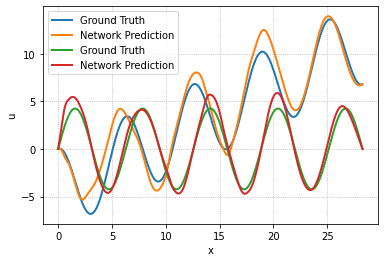

In [7]:
x_test = torch.linspace(0, 9*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")